In [3]:
!pip install pandas

  Using cached pandas-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [21]:
import sys
sys.path.append('../')

import boto3
from datetime import datetime, timedelta
import pandas as pd
from io import StringIO
import yaml

In [4]:
# Create a CloudWatch client
cloudwatch = boto3.client('cloudwatch', region_name='ap-southeast-1')

# Define the time period for the metrics
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=20*30)  # Adjusted for 20 months

# Bucket names to include in the metric queries
bucket_names = ['sabah', 'tangkahan', 'bukit-tiga-puluh', 'way-kambas', 'btp-abt-202307']

# Storage types to query for each bucket
storage_types = ['StandardStorage', 'IntelligentTieringFAStorage', 'IntelligentTieringIAStorage', 'IntelligentTieringAIAStorage']

# Generate metric queries for each bucket and storage type combination
metric_queries = []
for bucket in bucket_names:
    for storage_type in storage_types:
        query = {
            'Id': f"{bucket}_{storage_type}".lower().replace('-', '_'),  # Create a unique ID for the query
            'MetricStat': {
                'Metric': {
                    'Namespace': 'AWS/S3',
                    'MetricName': 'BucketSizeBytes',
                    'Dimensions': [
                        {'Name': 'BucketName', 'Value': bucket},
                        {'Name': 'StorageType', 'Value': storage_type}
                    ]
                },
                'Period': 86400,  # Daily
                'Stat': 'Average'
            }
        }
        metric_queries.append(query)
        
# Retrieve the metric data
response = cloudwatch.get_metric_data(
    MetricDataQueries=metric_queries,
    StartTime=start_time,
    EndTime=end_time
)

In [5]:
# Extract and prepare the data
data = []
for result in response['MetricDataResults']:
    # Add 'bucket' and 'storage_class' as new keys to the dictionary
    bucket, storage_class = result['Label'].split()
    result['bucket'] = bucket
    result['storage_class'] = storage_class
    for timestamp, value in zip(result['Timestamps'], result['Values']):
        data.append({
            'bucket': result['bucket'],
            'storage_class': result['storage_class'],
            'timestamp': timestamp,
            'GB': value / 1e9
        })

# Convert to DataFrame
df = pd.DataFrame(data)

In [22]:
# Current date in YYMMDD format
current_date = datetime.now().strftime('%y%m%d')

# CSV file name based on the current date
file_name = f'cloudwatch_{current_date}.csv'

# Convert the DataFrame to a CSV string
csv_buffer = StringIO()
df.to_csv(csv_buffer, index=False)

# Initialize a boto3 client for S3
s3_client = boto3.client('s3')

# Bucket name
bucket_name = 'metrics-of-buckets'

# Save the CSV file to S3
s3_client.put_object(Bucket=bucket_name, Key=file_name, Body=csv_buffer.getvalue())


{'ResponseMetadata': {'RequestId': '9TVRP2XGEP876JH8',
  'HostId': '4J+wGcdCqndx/sHXPFIcoNVvoz5SWbPhkg3smJwFP6+0rhaDH/T5kojFlceMjqCSmc2jJuQSkFg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '4J+wGcdCqndx/sHXPFIcoNVvoz5SWbPhkg3smJwFP6+0rhaDH/T5kojFlceMjqCSmc2jJuQSkFg=',
   'x-amz-request-id': '9TVRP2XGEP876JH8',
   'date': 'Tue, 12 Mar 2024 11:57:40 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"dcc873633cbe723a21a3b789d94f4347"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"dcc873633cbe723a21a3b789d94f4347"',
 'ServerSideEncryption': 'AES256'}

In [19]:
df.set_index(['bucket', 'timestamp', 'storage_class']).sort_values(['bucket', 'timestamp'])

GB  \
bucket         timestamp                 storage_class                                
btp-abt-202307 2023-06-11 10:00:00+00:00 StandardStorage               7.800000e-08   
               2023-06-12 10:00:00+00:00 StandardStorage               7.800000e-08   
               2023-06-13 10:00:00+00:00 StandardStorage               7.800000e-08   
               2023-06-14 10:00:00+00:00 StandardStorage               9.437728e-01   
               2023-06-15 10:00:00+00:00 StandardStorage               9.437728e-01   
...                                                                             ...   
way-kambas     2024-03-09 10:00:00+00:00 IntelligentTieringFAStorage   1.026330e-04   
                                         IntelligentTieringAIAStorage  1.783638e+02   
               2024-03-10 10:00:00+00:00 StandardStorage               1.867864e+01   
                                         IntelligentTieringFAStorage   1.026330e-04   
                                         IntelligentTieringAIAStorage  1.783638e+02   

                                                                          DailyCost  
bucket         timestamp                 storage_class                               
btp-abt-202307 2023-06-11 10:00:00+00:00 StandardStorage               6.406045e-11  
               2023-06-12 10:00:00+00:00 StandardStorage               6.406045e-11  
               2023-06-13 10:00:00+00:00 StandardStorage               6.406045e-11  
               2023-06-14 10:00:00+00:00 StandardStorage               7.751091e-04  
               2023-06-15 10:00:00+00:00 StandardStorage               7.751091e-04  
...                                                                             ...  
way-kambas     2024-03-09 10:00:00+00:00 IntelligentTieringFAStorage   8.429123e-08  
                                         IntelligentTieringAIAStorage  2.929759e-02  
               2024-03-10 10:00:00+00:00 StandardStorage               1.534054e-02  
                                         IntelligentTieringFAStorage   8.429123e-08  
                                         IntelligentTieringAIAStorage  2.929759e-02  

[2872 rows x 2 columns]

In [7]:
# Filter the DataFrame for the latest date
latest_date = df['timestamp'].max()
latest_data_df = df[df['timestamp'] == latest_date]

latest_data_df.set_index(['timestamp','bucket'])

storage_class  \
timestamp                 bucket                                           
2024-03-10 10:00:00+00:00 sabah                          StandardStorage   
                          sabah              IntelligentTieringFAStorage   
                          sabah             IntelligentTieringAIAStorage   
                          tangkahan                      StandardStorage   
                          tangkahan          IntelligentTieringFAStorage   
                          tangkahan          IntelligentTieringIAStorage   
                          tangkahan         IntelligentTieringAIAStorage   
                          bukit-tiga-puluh               StandardStorage   
                          bukit-tiga-puluh   IntelligentTieringFAStorage   
                          bukit-tiga-puluh   IntelligentTieringIAStorage   
                          bukit-tiga-puluh  IntelligentTieringAIAStorage   
                          way-kambas                     StandardStorage   
                          way-kambas         IntelligentTieringFAStorage   
                          way-kambas        IntelligentTieringAIAStorage   
                          btp-abt-202307                 StandardStorage   

                                                     GB  
timestamp                 bucket                         
2024-03-10 10:00:00+00:00 sabah               42.216740  
                          sabah                0.000124  
                          sabah             1771.088956  
                          tangkahan           51.302789  
                          tangkahan            0.000020  
                          tangkahan            0.913941  
                          tangkahan          765.825020  
                          bukit-tiga-puluh     7.080853  
                          bukit-tiga-puluh     8.294476  
                          bukit-tiga-puluh    57.509475  
                          bukit-tiga-puluh  3261.286176  
                          way-kambas          18.678640  
                          way-kambas           0.000103  
                          way-kambas         178.363752  
                          btp-abt-202307    1723.350779

/opt/conda/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



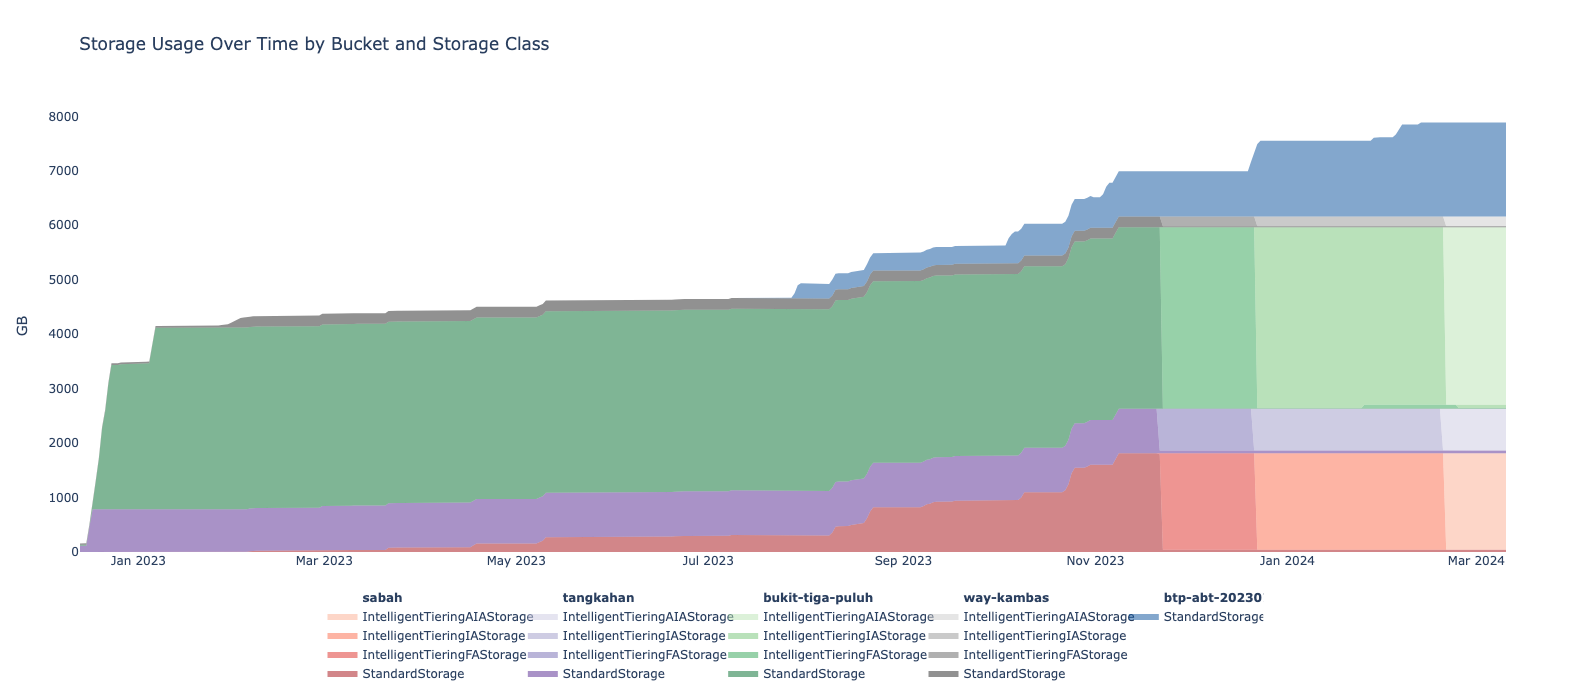

In [8]:
import plotly.graph_objects as go

# Your color scheme
color_scheme = {
    'sabah': {
        'StandardStorage': 'rgb(165,15,21,1)',  
        'IntelligentTieringFAStorage': 'rgb(222,45,38,1)',
        'IntelligentTieringIAStorage': 'rgb(251,106,74,1)',
        'IntelligentTieringAIAStorage': 'rgb(252,174,145,1)'
    },
    'tangkahan': {
        'StandardStorage': 'rgb(84,39,143)',  
        'IntelligentTieringFAStorage': 'rgb(117,107,177)',
        'IntelligentTieringIAStorage': 'rgb(158,154,200)',
        'IntelligentTieringAIAStorage': 'rgb(203,201,226)'
    },
    'way-kambas': {
        'StandardStorage': 'rgb(37,37,37)', 
        'IntelligentTieringFAStorage': 'rgb(99,99,99)',
        'IntelligentTieringIAStorage': 'rgb(150,150,150)',
        'IntelligentTieringAIAStorage': 'rgb(204,204,204)'
    },
    'bukit-tiga-puluh': {
        'StandardStorage': 'rgb(0,109,44)',  
        'IntelligentTieringFAStorage': 'rgb(49,163,84)',
        'IntelligentTieringIAStorage': 'rgb(116,196,118)',
        'IntelligentTieringAIAStorage': 'rgb(186,228,179)'
    },
    'btp-abt-202307': {
        'StandardStorage': 'rgb(8,81,156)',  # Now the darkest
        'IntelligentTieringFAStorage': 'rgb(49,130,189)',
        'IntelligentTieringIAStorage': 'rgb(107,174,214)',
        'IntelligentTieringAIAStorage': 'rgb(189,215,231)'
    }
}

# Create the figure
fig = go.Figure()

# Track the unique buckets for legend ordering
unique_buckets = df['bucket'].unique()

# Iterate over the DataFrame to add each trace
for bucket in unique_buckets:
    for storage_class in df[df['bucket'] == bucket]['storage_class'].unique():
        # Filter the DataFrame for the current bucket and storage class
        df_subset = df[(df['bucket'] == bucket) & (df['storage_class'] == storage_class)]
        color = color_scheme[bucket][storage_class]
        
        # Add trace to the figure
        fig.add_trace(go.Scatter(
            x=df_subset['timestamp'], 
            y=df_subset['GB'], 
            name=f"{storage_class}",  # Simplify name to just storage_class for clarity
            legendgroup=bucket,  # Use bucket name as legend group
            line=dict(color=color, width=0),
            stackgroup='one',  # Use bucket for stack grouping as well
            mode='lines',
            fill='tonexty'
        ))

# Update layout with custom legend settings
fig.update_layout(
    title='Storage Usage Over Time by Bucket and Storage Class',
    xaxis=dict(rangeslider_visible=False),
    yaxis=dict(title='GB'),
    legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5),
    plot_bgcolor='white',
    height=700
)

# Optionally, add a dummy trace for each bucket to act as a group title in the legend
for bucket in unique_buckets:
    fig.add_trace(go.Scatter(
        x=[None], 
        y=[None], 
        mode='markers',
        marker=dict(color='rgba(255,255,255,0)'),
        legendgroup=bucket,
        name=f'<b>{bucket}</b>'  # Bold bucket name for emphasis
    ))

# Show the plot
fig.show()


In [9]:
# filter for the first day of the month
df_month = df[df['timestamp'].dt.day == 1].copy()

# Extract just the date part from 'timestamp'
df_month['date'] = df_month['timestamp'].dt.date


# Define the desired order for 'storage_class'
storage_class_order = [
    'StandardStorage',
    'IntelligentTieringFAStorage',
    'IntelligentTieringIAStorage',
    'IntelligentTieringAIAStorage'
]

# Convert 'storage_class' to a categorical type with the defined order
df_month['storage_class'] = pd.Categorical(
    df_month['storage_class'],
    categories=storage_class_order,
    ordered=True
)

# Transform to wide format
df_month.pivot(
    index=['bucket', 'storage_class'],
    columns='date',
    values='GB'
  ).round(3).fillna('')

date                                          2023-01-01 2023-02-01  \
bucket           storage_class                                        
btp-abt-202307   StandardStorage                                      
bukit-tiga-puluh StandardStorage                2674.418   3334.131   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
sabah            StandardStorage                              1.907   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
tangkahan        StandardStorage                 784.343    784.343   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
way-kambas       StandardStorage                  33.416     146.74   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         

date                                          2023-03-01 2023-04-01  \
bucket           storage_class                                        
btp-abt-202307   StandardStorage                                      
bukit-tiga-puluh StandardStorage                3334.131   3334.131   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
sabah            StandardStorage                  26.992     81.231   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
tangkahan        StandardStorage                 817.514    817.514   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
way-kambas       StandardStorage                 196.857    196.857   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         

date                                          2023-05-01 2023-06-01  \
bucket           storage_class                                        
btp-abt-202307   StandardStorage                                      
bukit-tiga-puluh StandardStorage                3334.131   3334.131   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
sabah            StandardStorage                 156.128    270.144   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
tangkahan        StandardStorage                 817.514    817.628   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
way-kambas       StandardStorage                 196.857    196.857   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 Intel

In [10]:
# Ensure 'timestamp' is a datetime type
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define the cost per GB per month
cost_per_gb_per_month = {
    'StandardStorage': 0.025,
    'Standard-IA': 0.0138,
    'IntelligentTieringFAStorage': 0.025,
    'IntelligentTieringIAStorage': 0.0138,
    'IntelligentTieringAIAStorage': 0.005,
    'IntelligentTieringAAStorage': 0.0045,  
    'IntelligentTieringADAStorage': 0.002,
    'infrequentAccess': 0.0138,
    'GlacierInstant': 0.005,
    'GlacierDeep': 0.002
}

# Convert monthly rates to daily rates by dividing by the average number of days in a month
cost_per_gb_per_day = {k: v / 30.44 for k, v in cost_per_gb_per_month.items()}

df['DailyCost'] = df.apply(
    lambda row: row['GB']*cost_per_gb_per_day[row['storage_class']],
    axis=1
)


monthly_costs = df.groupby([
    'bucket',
    'storage_class',
    pd.Grouper(key='timestamp', freq='M')
  ]).agg(cost=('DailyCost', 'sum')).reset_index()

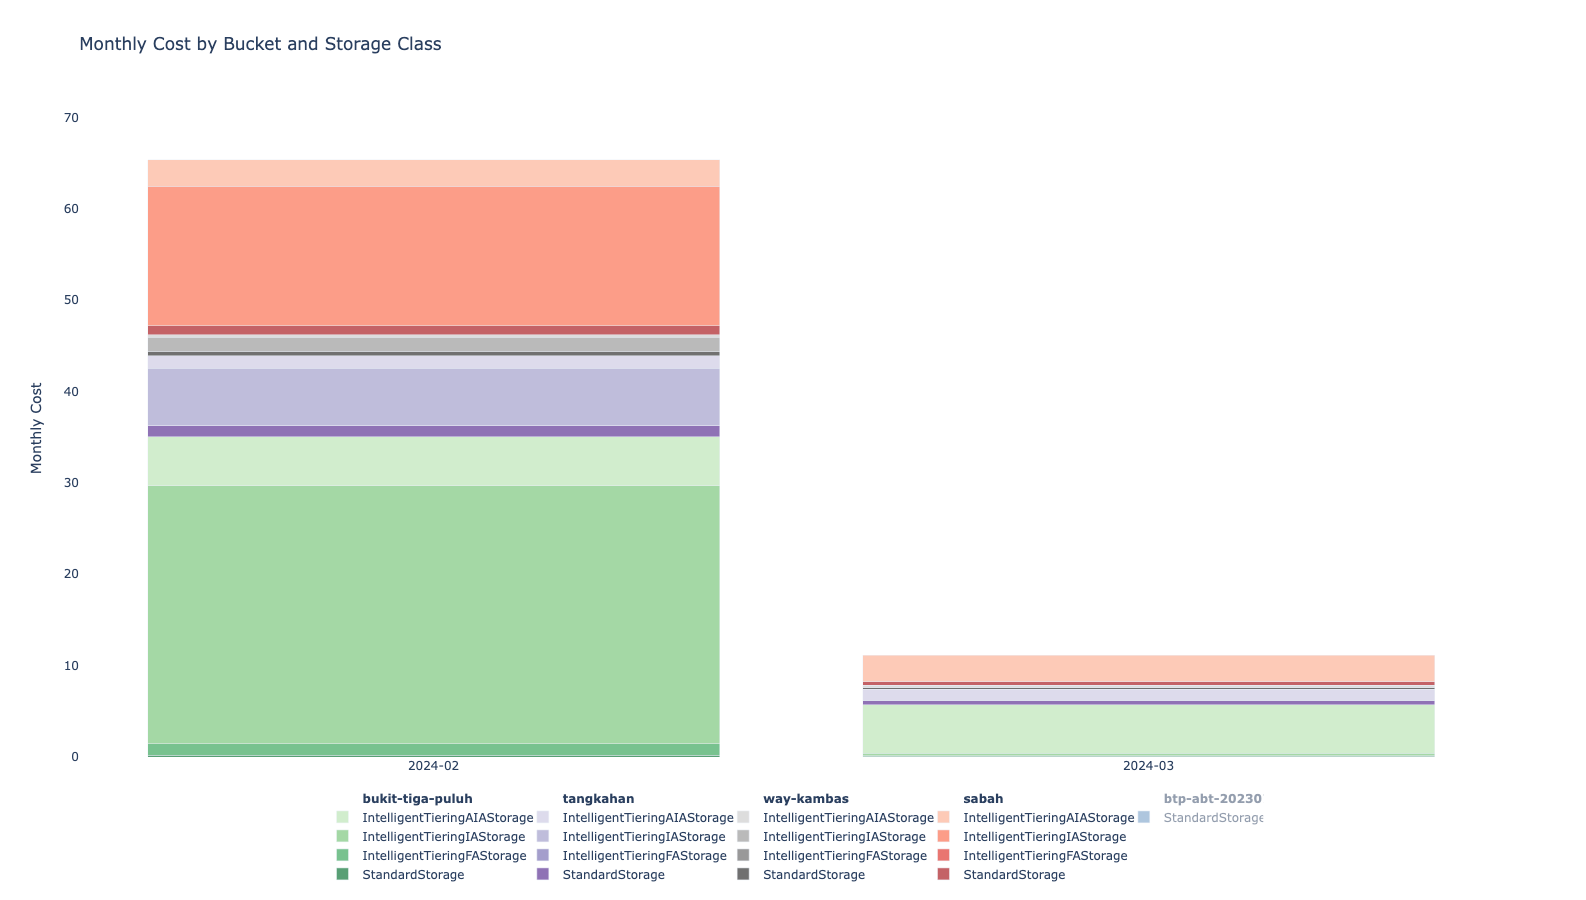

In [11]:

# Initialize figure
fig = go.Figure()

# Get unique values for plotting
# Ensure 'timestamp' is a datetime type and sort
monthly_costs['timestamp'] = pd.to_datetime(monthly_costs['timestamp'])
monthly_costs.sort_values(by=['timestamp', 'bucket', 'storage_class'], inplace=True)
monthly_costs['YearMonth'] = monthly_costs['timestamp'].dt.strftime('%Y-%m')
months = monthly_costs['YearMonth'].unique()
buckets = monthly_costs['bucket'].unique()
storage_classes = monthly_costs['storage_class'].unique()

# Create a mapping for x-axis positioning
month_positions = {month: i for i, month in enumerate(months)}

# Plot each storage class for each bucket
for bucket in buckets:
    for storage_class in storage_classes:
        df_filtered = monthly_costs[(monthly_costs['bucket'] == bucket) & (monthly_costs['storage_class'] == storage_class)]
        
        if not df_filtered.empty:
            # Find the position offset for each bucket within a month
            x_values = [month_positions[month] for month in df_filtered['YearMonth']]
            
            fig.add_trace(go.Bar(
                x=x_values,
                y=df_filtered['cost'],
                name=f"{storage_class}",
                marker_color=color_scheme[bucket][storage_class],
                opacity=0.65,
                legendgroup=bucket,  # This groups legend entries by bucket
                offsetgroup=bucket,  # This ensures bars for the same bucket are grouped
            ))

# Customize the x-axis to show month names
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(month_positions.values()),
        ticktext = list(month_positions.keys())
    ),
    barmode='stack',  # Stack bars by storage class within each bucket group
    title="Monthly Cost by Bucket and Storage Class",
    yaxis_title="Monthly Cost",
    legend=dict(orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5),
    plot_bgcolor='white',
    height=900
)

for bucket in unique_buckets:
    fig.add_trace(go.Scatter(
        x=[None], 
        y=[None], 
        mode='markers',
        marker=dict(color='rgba(255,255,255,0)'),
        legendgroup=bucket,
        name=f'<b>{bucket}</b>'  # Bold bucket name for emphasis
    ))


fig.show()


In [14]:
monthly_costs['date'] = monthly_costs['timestamp'].dt.date

# Define the desired order for 'storage_class'
storage_class_order = [
    'StandardStorage',
    'IntelligentTieringFAStorage',
    'IntelligentTieringIAStorage',
    'IntelligentTieringAIAStorage'
]

# Convert 'storage_class' to a categorical type with the defined order
monthly_costs['storage_class'] = pd.Categorical(
    monthly_costs['storage_class'],
    categories=storage_class_order,
    ordered=True
)

monthly_costs.pivot(
    index=['bucket', 'storage_class'],
    columns='date', 
    values='cost'
).round(2).fillna('')

date                                          2022-12-31 2023-01-31  \
bucket           storage_class                                        
btp-abt-202307   StandardStorage                                      
bukit-tiga-puluh StandardStorage                   25.54      82.47   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
sabah            StandardStorage                                0.0   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
tangkahan        StandardStorage                   10.32      19.97   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
way-kambas       StandardStorage                    0.46       1.03   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         

date                                          2023-02-28 2023-03-31  \
bucket           storage_class                                        
btp-abt-202307   StandardStorage                                      
bukit-tiga-puluh StandardStorage                   76.67      84.89   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
sabah            StandardStorage                    0.49       1.28   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
tangkahan        StandardStorage                   18.06      20.81   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
way-kambas       StandardStorage                    4.39       5.01   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         

date                                          2023-04-30 2023-05-31  \
bucket           storage_class                                        
btp-abt-202307   StandardStorage                                      
bukit-tiga-puluh StandardStorage                   82.15      84.89   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
sabah            StandardStorage                    2.93        6.1   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
tangkahan        StandardStorage                   20.14      20.81   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 IntelligentTieringAIAStorage                         
way-kambas       StandardStorage                    4.85       5.01   
                 IntelligentTieringFAStorage                          
                 IntelligentTieringIAStorage                          
                 Intel

In [15]:
monthly_costs.groupby(['date','bucket']).\
  agg({'cost':'sum'}).\
  reset_index().\
  pivot(index=['bucket'], columns='date', values='cost').\
  round(2).\
  fillna('')

date             2022-12-31 2023-01-31 2023-02-28 2023-03-31 2023-04-30  \
bucket                                                                    
btp-abt-202307                                                            
bukit-tiga-puluh      25.54      82.47      76.67      84.89      82.15   
sabah                              0.0       0.49       1.28       2.93   
tangkahan             10.32      19.97      18.06      20.81      20.14   
way-kambas             0.46       1.03       4.39       5.01       4.85   

date             2023-05-31  2023-06-30  2023-07-31  2023-08-31  2023-09-30  \
bucket                                                                        
btp-abt-202307                     0.00        0.72        7.55        8.03   
bukit-tiga-puluh      84.89       82.15       84.89       84.89       82.15   
sabah                   6.1        6.96        7.89       14.28       22.37   
tangkahan             20.81       20.15       20.84       20.84       20.16   
way-kambas             5.01        4.85        5.01        5.01        4.85   

date              2023-10-31  2023-11-30  2023-12-31  2024-01-31  2024-02-29  \
bucket                                                                         
btp-abt-202307         14.06       19.77       26.11       35.62       39.93   
bukit-tiga-puluh       84.89       82.15       72.65       47.11       35.06   
sabah                  30.18       43.56       39.65       25.97       19.17   
tangkahan              20.83       20.16       17.73       12.09        8.87   
way-kambas              5.02        4.85        4.36        2.98        2.27   

date              2024-03-31  
bucket                        
btp-abt-202307         14.15  
bukit-tiga-puluh        5.74  
sabah                   3.26  
tangkahan               1.68  
way-kambas              0.45

In [16]:
monthly_costs.groupby(['date']).\
  agg({'cost':'sum'})

cost
date                  
2022-12-31   36.323502
2023-01-31  103.467515
2023-02-28   99.612145
2023-03-31  111.992525
2023-04-30  110.070058
2023-05-31  116.812021
2023-06-30  114.110367
2023-07-31  119.347128
2023-08-31  132.569215
2023-09-30  137.566120
2023-10-31  154.971065
2023-11-30  170.488211
2023-12-31  160.493408
2024-01-31  123.765790
2024-02-29  105.303878
2024-03-31   25.283238

projection of costs for btp-abt-202307

In [17]:
cost_per_gb_per_day

{'StandardStorage': 0.0008212877792378449,
 'Standard-IA': 0.00045335085413929037,
 'IntelligentTieringFAStorage': 0.0008212877792378449,
 'IntelligentTieringIAStorage': 0.00045335085413929037,
 'IntelligentTieringAIAStorage': 0.000164257555847569,
 'IntelligentTieringAAStorage': 0.00014783180026281206,
 'IntelligentTieringADAStorage': 6.570302233902759e-05,
 'infrequentAccess': 0.00045335085413929037,
 'GlacierInstant': 0.000164257555847569,
 'GlacierDeep': 6.570302233902759e-05}

In [18]:
# Define the data collection period and daily data volume
start_date = '2024-03-01'
end_date = '2024-12-31'
daily_data_volume = 0.109 * 24 * 50  # Adjusted daily data volume calculation

# Generate the DataFrame for data collection
creation_dates = pd.date_range(start=start_date, end=end_date)
evaluation_dates = pd.date_range(start=start_date, end=end_date)

# Create combinations of creation_date and each subsequent date including and after creation_date
all_combinations = [(creation_date, date, daily_data_volume) 
                    for creation_date in creation_dates 
                    for date in evaluation_dates 
                    if date >= creation_date]

# Convert to DataFrame
btp_abt_df_extended = pd.DataFrame(all_combinations, columns=['creation_date', 'date', 'GB'])


# Revised tiering strategies with correct transitions
tierings = {
    'automatic_access_tiers': {
        'IntelligentTieringFAStorage': 30, 
        'IntelligentTieringIAStorage': 90,
        'IntelligentTieringAIAStorage': float('inf')  # Transition to AIA after 90 days without further condition
    },
    'opt_in_asynchrounous_deep_archive_tier': {
        'IntelligentTieringFAStorage': 30, 
        'IntelligentTieringIAStorage': 90, 
        'IntelligentTieringAIAStorage': 180,  # Transition to AIA after 90 days, then ADA after 180 days
        'IntelligentTieringADAStorage': float('inf')  # Final tier in this strategy
    },
    'both_opt_in_asynchrounous_deep_archive_tiers': {
        'IntelligentTieringFAStorage': 30,
        'IntelligentTieringIAStorage': 90,
        'IntelligentTieringAAStorage': 180,  # Transition to AA after 90 days, then DA after 180 days
        'IntelligentTieringADAStorage': float('inf')  # Final tier in this strategy
    },
    'custom':{
        'infrequentAccess': 14,
        'GlacierInstant': float('inf'),
    
    },
    'custom2':{
        'infrequentAccess': 7,
        'GlacierDeep': float('inf'),
    
    }
}

# Corrected function to determine the storage class with updated tiering transitions
def determine_storage_class(row, tiering):
    days_old = (row['date'] - row['creation_date']).days
    for storage_class, threshold in tierings[tiering].items():
        if days_old < threshold:
            return storage_class
        
def apply_tiering_strategy(df, strategy_name):
    """
    Apply a given tiering strategy to a DataFrame.

    Parameters:
    - df: DataFrame to apply the strategy to.
    - strategy_name: Name of the tiering strategy.
    - tiering_rules: Dictionary with tiering thresholds.

    Returns:
    - DataFrame with an applied tiering strategy.
    """
    # Copy df to avoid modifying the original DataFrame
    temp_df = df.copy()
    
    # Use the global determine_storage_class function
    temp_df['storage_class'] = temp_df.apply(lambda row: determine_storage_class(row, strategy_name), axis=1)
    temp_df['tiering_strategy'] = strategy_name  # Add tiering strategy name for identification

    return temp_df


btp_abt_df_extended

creation_date       date     GB
0        2024-03-01 2024-03-01  130.8
1        2024-03-01 2024-03-02  130.8
2        2024-03-01 2024-03-03  130.8
3        2024-03-01 2024-03-04  130.8
4        2024-03-01 2024-03-05  130.8
...             ...        ...    ...
46966    2024-12-29 2024-12-30  130.8
46967    2024-12-29 2024-12-31  130.8
46968    2024-12-30 2024-12-30  130.8
46969    2024-12-30 2024-12-31  130.8
46970    2024-12-31 2024-12-31  130.8

[46971 rows x 3 columns]

In [142]:
btp_abt_df_extended['creation_date'] = pd.to_datetime(btp_abt_df_extended['creation_date'])

btp_abt_df_extended.groupby(
    pd.Grouper(key='creation_date', freq='M')
)['GB'].sum()

creation_date
2024-03-31    1179946.8
2024-04-30    1022202.0
2024-05-31     932604.0
2024-06-30     782838.0
2024-07-31     685261.2
2024-08-31     559562.4
2024-09-30     421830.0
2024-10-31     312219.6
2024-11-30     182466.0
2024-12-31      64876.8
Freq: M, Name: GB, dtype: float64

In [132]:
# Initialize an empty DataFrame to store results
combined_df = pd.DataFrame()
# Loop through each tiering strategy and apply it to the dataset
for strategy in tierings.keys():
    _df = apply_tiering_strategy(btp_abt_df_extended, strategy)
    combined_df = pd.concat([combined_df, _df])
# Reset the index of the combined DataFrame
combined_df.reset_index(drop=True, inplace=True)    

# Summarize the total cumulative GB per storage class on each date
btp_abt_df = combined_df.groupby([
    'tiering_strategy', 'date', 'storage_class'
  ])['GB'].sum().reset_index()

btp_abt_df['cost'] = btp_abt_df.apply(
    lambda row: row['GB']*cost_per_gb_per_day[row['storage_class']],
    axis=1
)

btp_abt_df

tiering_strategy       date  \
0                     automatic_access_tiers 2024-03-01   
1                     automatic_access_tiers 2024-03-02   
2                     automatic_access_tiers 2024-03-03   
3                     automatic_access_tiers 2024-03-04   
4                     automatic_access_tiers 2024-03-05   
...                                      ...        ...   
3844  opt_in_asynchrounous_deep_archive_tier 2024-12-30   
3845  opt_in_asynchrounous_deep_archive_tier 2024-12-31   
3846  opt_in_asynchrounous_deep_archive_tier 2024-12-31   
3847  opt_in_asynchrounous_deep_archive_tier 2024-12-31   
3848  opt_in_asynchrounous_deep_archive_tier 2024-12-31   

                     storage_class       GB      cost  
0      IntelligentTieringFAStorage    130.8  0.107424  
1      IntelligentTieringFAStorage    261.6  0.214849  
2      IntelligentTieringFAStorage    392.4  0.322273  
3      IntelligentTieringFAStorage    523.2  0.429698  
4      IntelligentTieringFAStorage    654.0  0.537122  
...                            ...      ...       ...  
3844   IntelligentTieringIAStorage   7848.0  3.557898  
3845  IntelligentTieringADAStorage  16480.8  1.082838  
3846  IntelligentTieringAIAStorage  11772.0  1.933640  
3847   IntelligentTieringFAStorage   3924.0  3.222733  
3848   IntelligentTieringIAStorage   7848.0  3.557898  

[3849 rows x 5 columns]

In [124]:
btp_abt_df[btp_abt_df['tiering_strategy']=='custom']

tiering_strategy       date     storage_class       GB      cost
1722           custom 2024-03-01  infrequentAccess    130.8  0.059298
1723           custom 2024-03-02  infrequentAccess    261.6  0.118597
1724           custom 2024-03-03  infrequentAccess    392.4  0.177895
1725           custom 2024-03-04  infrequentAccess    523.2  0.237193
1726           custom 2024-03-05  infrequentAccess    654.0  0.296491
...               ...        ...               ...      ...       ...
2315           custom 2024-12-29  infrequentAccess   1831.2  0.830176
2316           custom 2024-12-30    GlacierInstant  38062.8  6.252102
2317           custom 2024-12-30  infrequentAccess   1831.2  0.830176
2318           custom 2024-12-31    GlacierInstant  38193.6  6.273587
2319           custom 2024-12-31  infrequentAccess   1831.2  0.830176

[598 rows x 5 columns]

In [84]:
# Example: Applying the function with the opt-in asynchronous deep archive tier strategy
tiering_strategy = 'opt_in_asynchrounous_deep_archive_tier'
btp_abt_df_extended['storage_class'] = btp_abt_df_extended.apply(
    lambda row: determine_storage_class(row, tiering=tiering_strategy),
    axis=1
)

# Summarize the total cumulative GB per storage class on each date
btp_abt_df = btp_abt_df_extended.groupby(['date', 'storage_class'])['GB'].sum().reset_index()


btp_abt_df['cost'] = btp_abt_df.apply(
    lambda row: row['GB']*cost_per_gb_per_day[row['storage_class']],
    axis=1
)

btp_abt_df

date                 storage_class       GB      cost
0   2024-03-01   IntelligentTieringFAStorage    130.8  0.107424
1   2024-03-02   IntelligentTieringFAStorage    261.6  0.214849
2   2024-03-03   IntelligentTieringFAStorage    392.4  0.322273
3   2024-03-04   IntelligentTieringFAStorage    523.2  0.429698
4   2024-03-05   IntelligentTieringFAStorage    654.0  0.537122
..         ...                           ...      ...       ...
919 2024-12-30   IntelligentTieringIAStorage   7848.0  3.557898
920 2024-12-31  IntelligentTieringADAStorage  16480.8  1.082838
921 2024-12-31  IntelligentTieringAIAStorage  11772.0  1.933640
922 2024-12-31   IntelligentTieringFAStorage   3924.0  3.222733
923 2024-12-31   IntelligentTieringIAStorage   7848.0  3.557898

[924 rows x 4 columns]

In [126]:
storage_classes

array(['IntelligentTieringFAStorage', 'IntelligentTieringIAStorage',
       'IntelligentTieringAIAStorage', 'IntelligentTieringADAStorage'],
      dtype=object)

/opt/conda/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



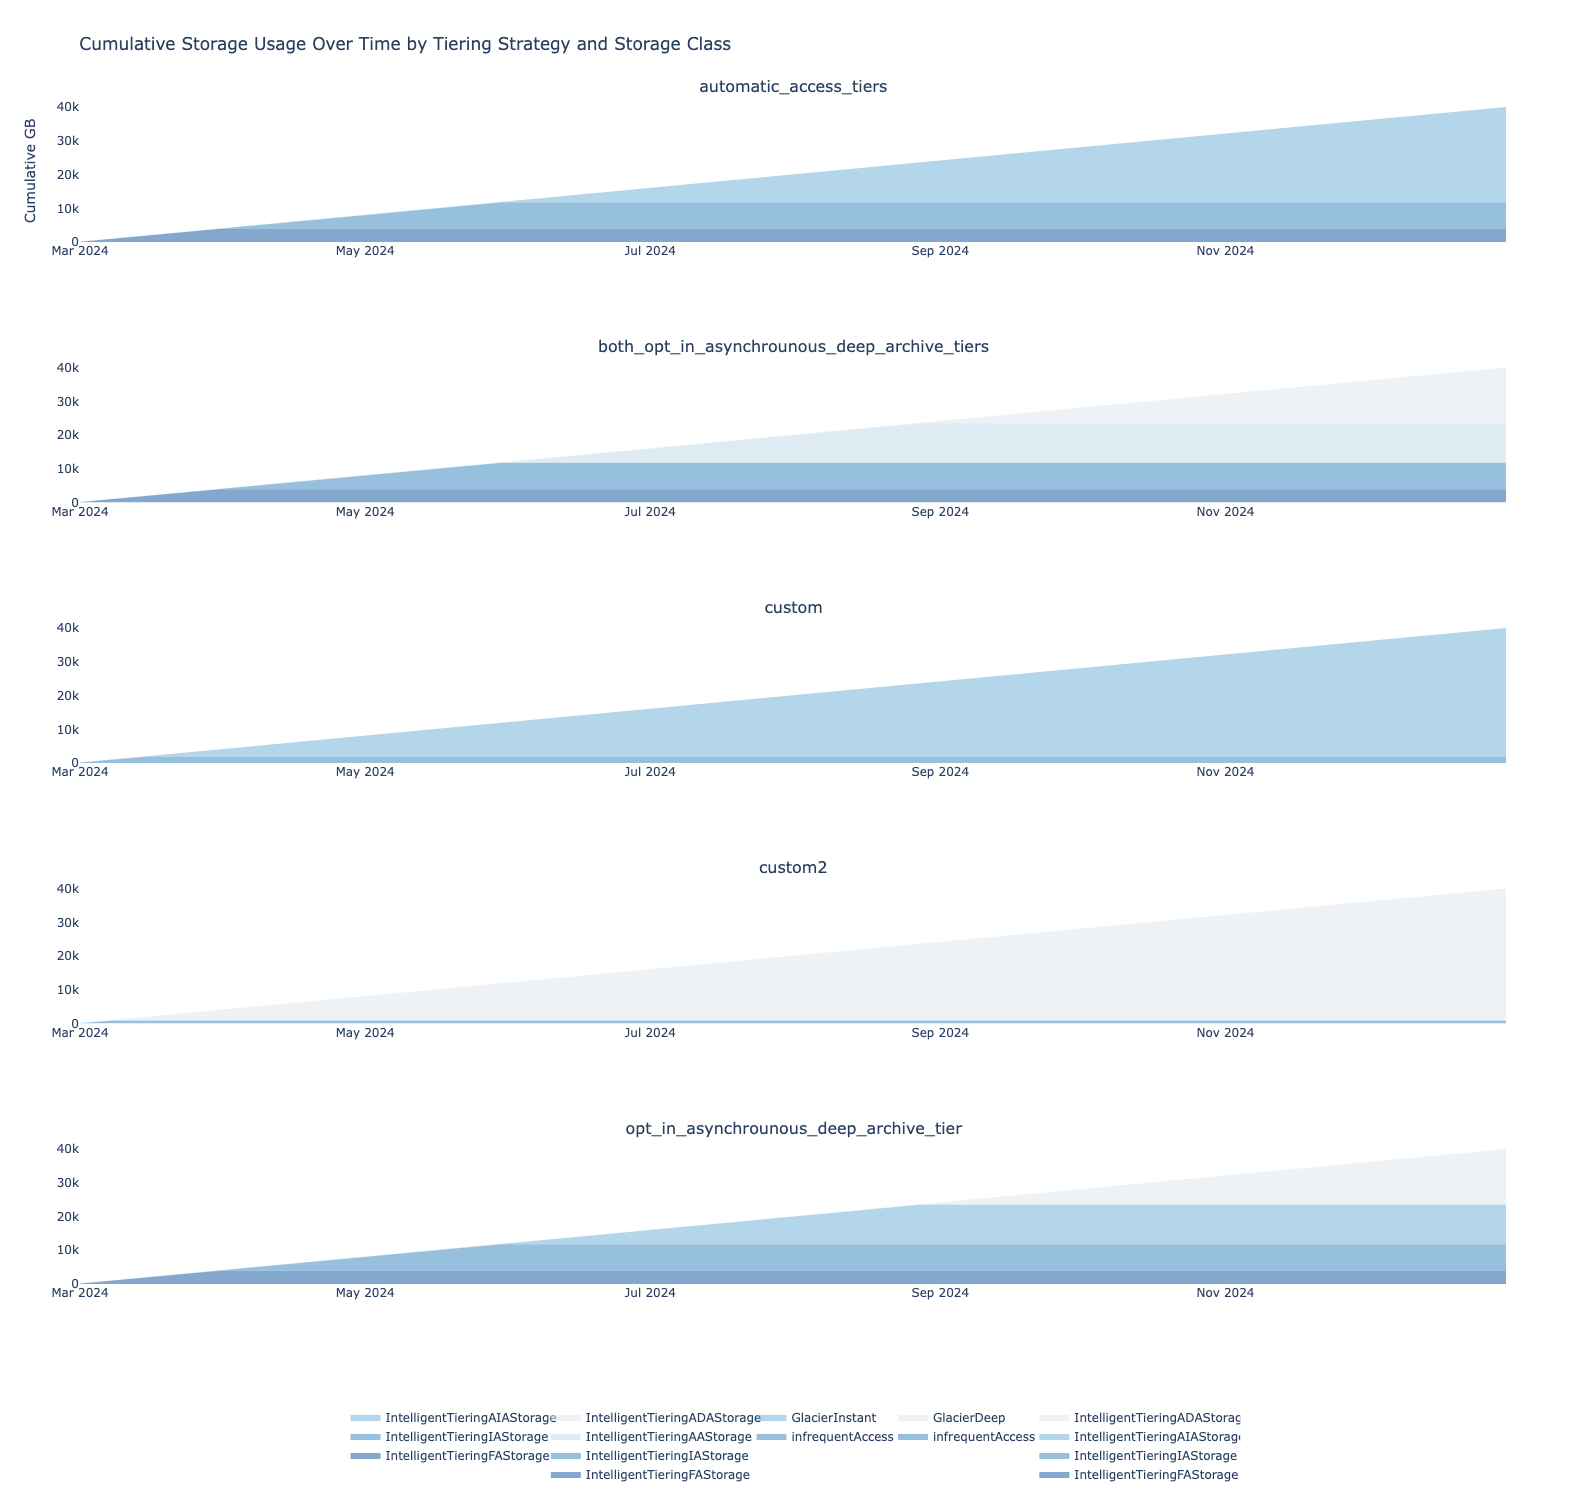

In [133]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming _df is your DataFrame with all tiering strategies applied and costs calculated

# Unique tiering strategies for creating subplots
tiering_strategies = btp_abt_df['tiering_strategy'].unique()
storage_classes =  btp_abt_df['storage_class'].unique()


# Color scheme adapted for storage classes
color_scheme = {
    'IntelligentTieringFAStorage': 'rgb(8,81,156)',
    'IntelligentTieringIAStorage': 'rgb(49,130,189)',
    'IntelligentTieringAIAStorage': 'rgb(107,174,214)',
    'IntelligentTieringAAStorage': 'rgb(189,215,231)',  
    'IntelligentTieringADAStorage': 'rgb(220,230,240)',
    'infrequentAccess': 'rgb(49,130,189)',
    'GlacierInstant': 'rgb(107,174,214)',
    'GlacierDeep': 'rgb(220,230,240)'
}

# Determine the number of rows for subplots based on the number of tiering strategies
num_rows = len(tiering_strategies)

# Create subplots, one row for each tiering strategy
fig = make_subplots(rows=num_rows, cols=1, subplot_titles=tiering_strategies)

# Iterate through each tiering strategy and add data to the respective subplot
for i, strategy in enumerate(tiering_strategies, start=1):
    df_subset = btp_abt_df[btp_abt_df['tiering_strategy'] == strategy]
    # Iterate over the unique storage classes to add each trace
    for storage_class in storage_classes:
        df_storage_class = df_subset[df_subset['storage_class'] == storage_class]
        color = color_scheme[storage_class]
        
        # Add traces
        fig.add_trace(
            go.Scatter(
                x=df_storage_class['date'],
                y=df_storage_class['GB'],
                name=f"{storage_class}",
                legendgroup=strategy,
                line=dict(color=color, width=0),
                mode='lines',
                stackgroup=strategy,  # Use strategy as stackgroup name
                fill='tonexty'
            ),
            row=i,
            col=1
        )



# Update layout
fig.update_layout(
    title='Cumulative Storage Usage Over Time by Tiering Strategy and Storage Class',
    yaxis_title='Cumulative GB',
    plot_bgcolor='white',
    legend=dict(orientation="h", xanchor="center", x=0.5),
    height=300*num_rows,  # Adjust height based on the number of rows
    width=1200
)

fig.show()


In [134]:
btp_abt_monthly= btp_abt_df.groupby([
    pd.Grouper(key='date', freq='M'),
    'tiering_strategy',
    'storage_class'
  ]).agg({'cost': 'sum'}).round(2).reset_index()
btp_abt_monthly

date                              tiering_strategy  \
0   2024-03-31                        automatic_access_tiers   
1   2024-03-31                        automatic_access_tiers   
2   2024-03-31  both_opt_in_asynchrounous_deep_archive_tiers   
3   2024-03-31  both_opt_in_asynchrounous_deep_archive_tiers   
4   2024-03-31                                        custom   
..         ...                                           ...   
129 2024-12-31                                       custom2   
130 2024-12-31        opt_in_asynchrounous_deep_archive_tier   
131 2024-12-31        opt_in_asynchrounous_deep_archive_tier   
132 2024-12-31        opt_in_asynchrounous_deep_archive_tier   
133 2024-12-31        opt_in_asynchrounous_deep_archive_tier   

                    storage_class    cost  
0     IntelligentTieringFAStorage   53.18  
1     IntelligentTieringIAStorage    0.06  
2     IntelligentTieringFAStorage   53.18  
3     IntelligentTieringIAStorage    0.06  
4                  GlacierInstant    3.29  
..                            ...     ...  
129              infrequentAccess   12.87  
130  IntelligentTieringADAStorage   29.57  
131  IntelligentTieringAIAStorage   59.94  
132   IntelligentTieringFAStorage   99.90  
133   IntelligentTieringIAStorage  110.29  

[134 rows x 4 columns]

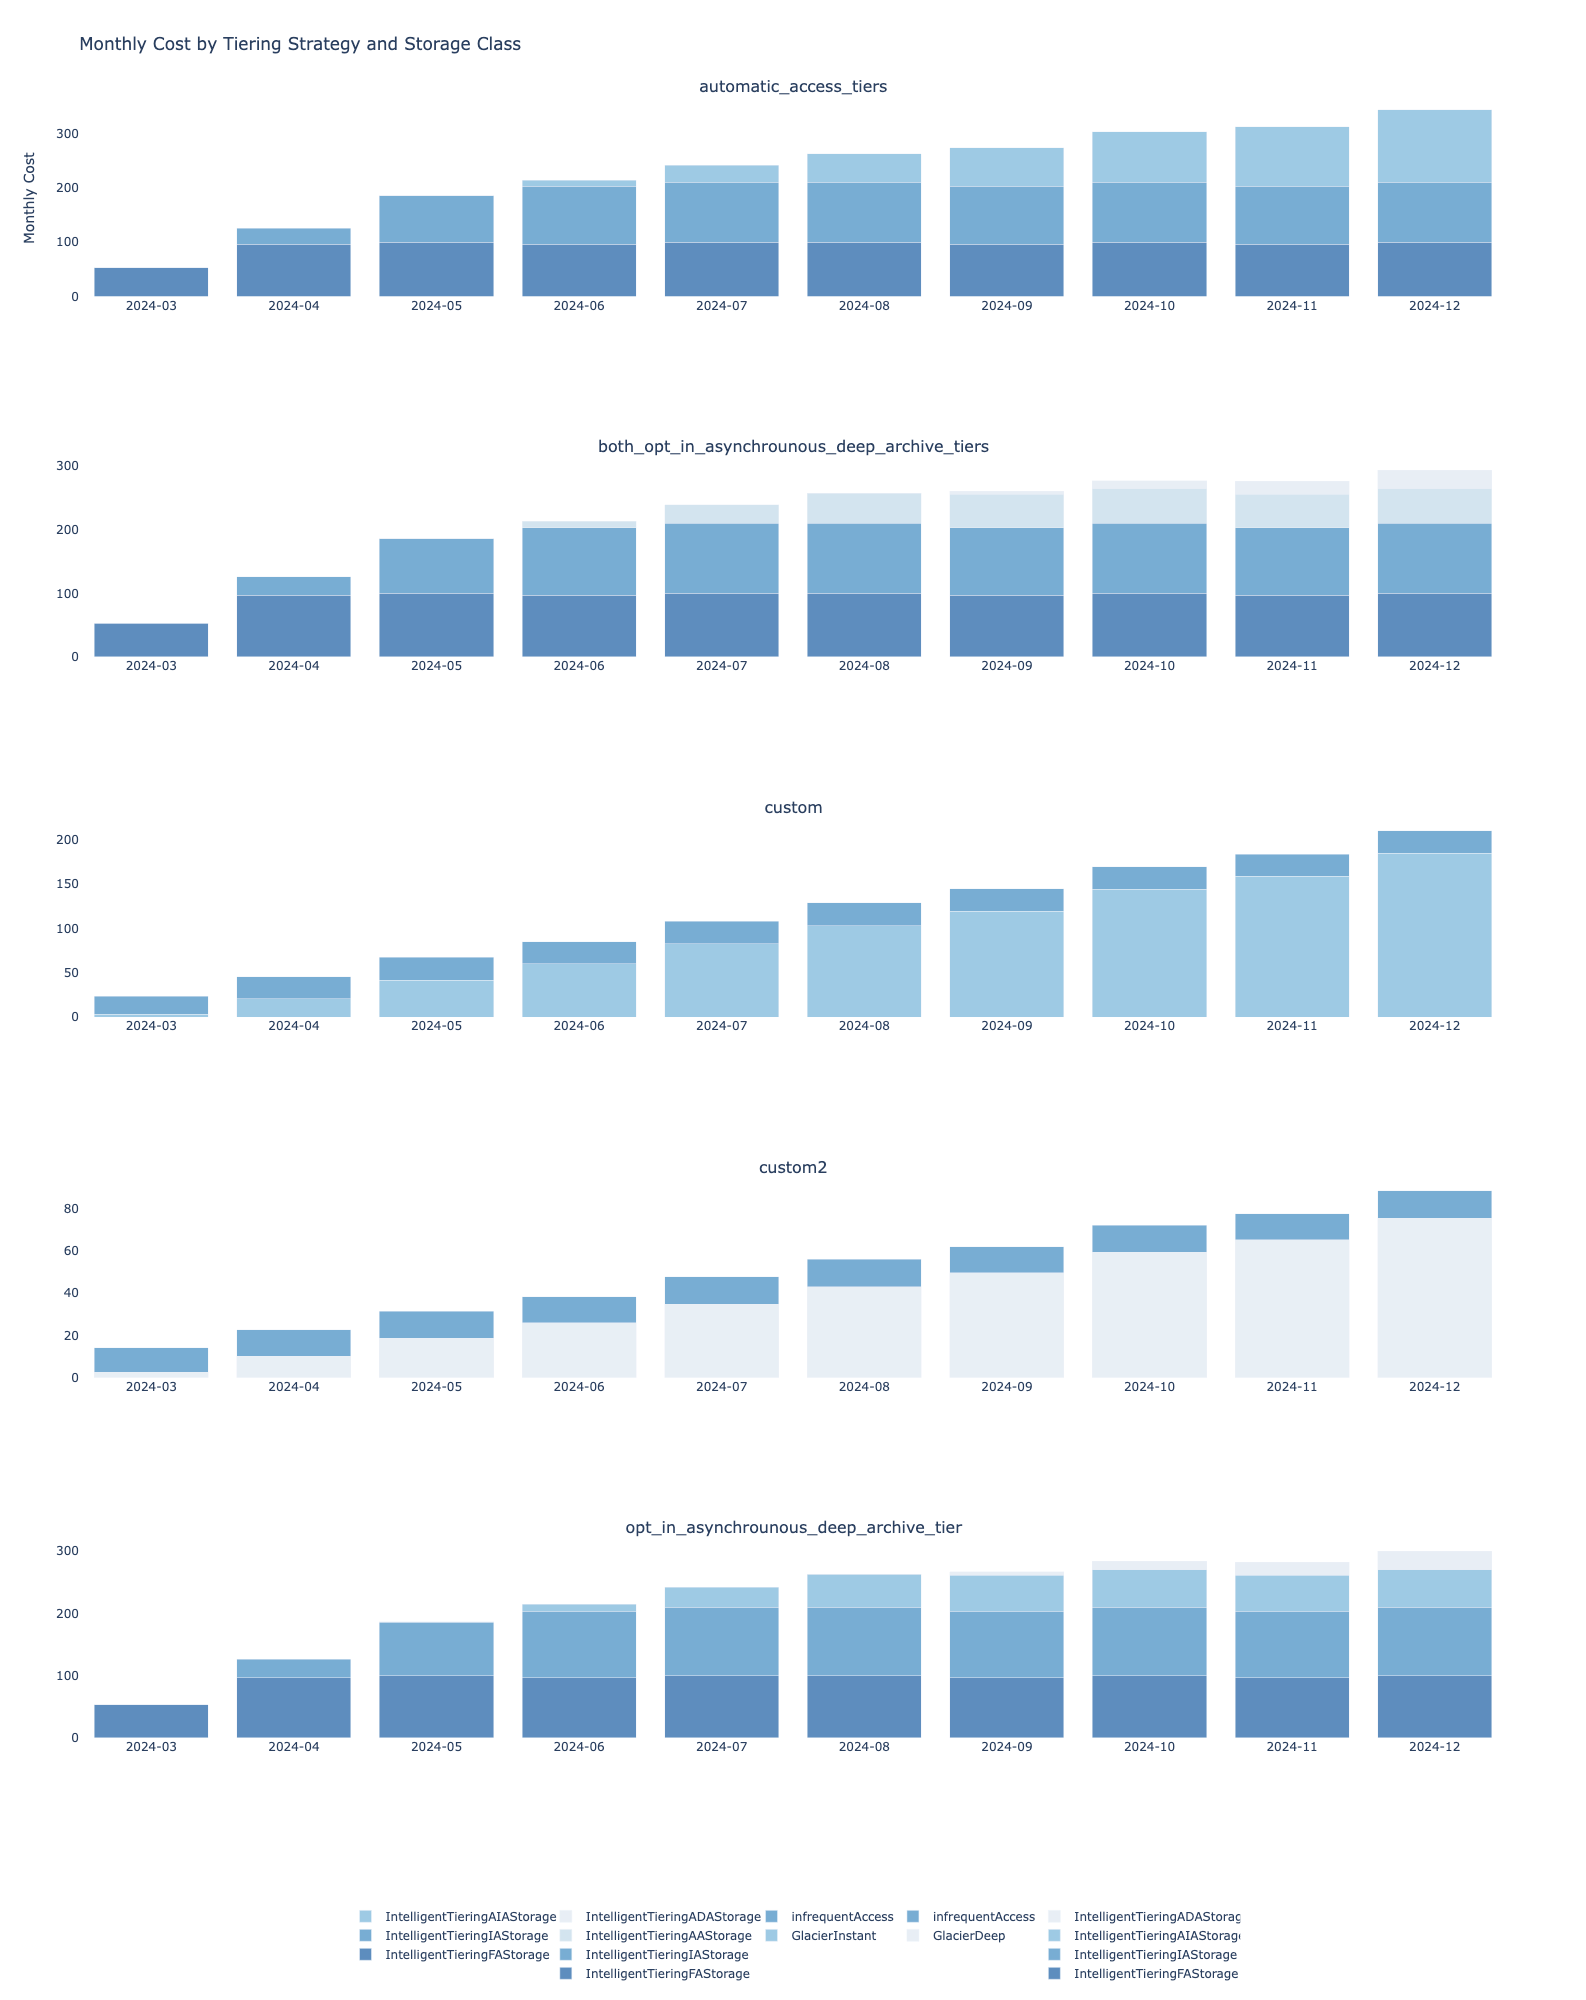

In [135]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming btp_abt_monthly is your DataFrame

# Convert 'date' column to datetime if it's not already
btp_abt_monthly['date'] = pd.to_datetime(btp_abt_monthly['date'])
btp_abt_monthly['YearMonth'] = btp_abt_monthly['date'].dt.strftime('%Y-%m')
months = btp_abt_monthly['YearMonth'].unique()

# Get unique tiering strategies and months
tiering_strategies = btp_abt_monthly['tiering_strategy'].unique()


# Initialize subplots
fig = make_subplots(rows=len(tiering_strategies), cols=1, subplot_titles=tiering_strategies)

# Loop over each tiering strategy
for i, strategy in enumerate(tiering_strategies, start=1):
    df_strategy = btp_abt_monthly[btp_abt_monthly['tiering_strategy'] == strategy].copy()
    
    # Loop over each storage class
    for storage_class in df_strategy['storage_class'].unique():
        df_filtered = df_strategy[df_strategy['storage_class'] == storage_class].copy()
        # Assign x-axis positions based on the unique months
        x_values = [month_positions[month] for month in df_filtered['YearMonth']]
        # Add trace to the subplot
        fig.add_trace(go.Bar(
            x= x_values,#df_agg['x_pos'],
            y=df_filtered['cost'],#df_agg['cost'],
            name=storage_class,
            opacity=0.65,
            marker_color=color_scheme[storage_class],
            legendgroup=strategy,  # Group legends by strategy
        ), row=i, col=1)
        
# Customize x-axis to display 'YearMonth' labels
fig.update_xaxes(tickmode='array', tickvals=list(range(len(months))), ticktext=list(months))

# Update layout
fig.update_layout(
    height=400*len(tiering_strategies),
    width=800,
    barmode='stack',
    title="Monthly Cost by Tiering Strategy and Storage Class",
    yaxis_title="Monthly Cost",
    legend=dict(orientation="h", y=-0.1, x=0.5, xanchor='center'),
    plot_bgcolor='white'
)

fig.show()


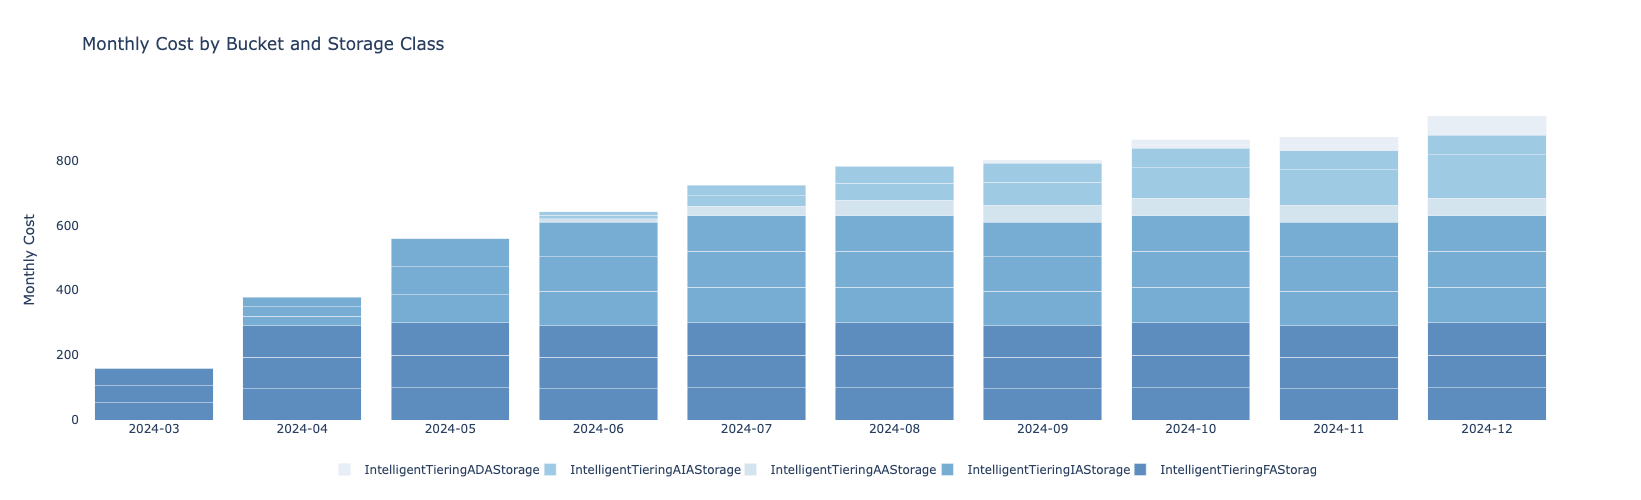

In [99]:
btp_abt_monthly.sort_values(by=['date', 'storage_class'], inplace=True)
btp_abt_monthly['YearMonth'] = btp_abt_monthly['date'].dt.strftime('%Y-%m')
months = btp_abt_monthly['YearMonth'].unique()
storage_classes = btp_abt_monthly['storage_class'].unique()

# Create a mapping for x-axis positioning
month_positions = {month: i for i, month in enumerate(months)}

fig = go.Figure()

for storage_class in storage_classes:
    df_filtered = btp_abt_monthly[btp_abt_monthly['storage_class'] == storage_class]
    
    if not df_filtered.empty:
        # Find the position offset for each bucket within a month
        x_values = [month_positions[month] for month in df_filtered['YearMonth']]
            
        fig.add_trace(go.Bar(
            x=x_values,
            y=df_filtered['cost'],
            name=f"{storage_class}",
            marker_color=color_scheme[storage_class],
            opacity=0.65
        ))
        
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(month_positions.values()),
        ticktext = list(month_positions.keys())
    ),
    barmode='stack',  # Stack bars by storage class within each bucket group
    title="Monthly Cost by Bucket and Storage Class",
    yaxis_title="Monthly Cost",
    plot_bgcolor='white',
    legend=dict(orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5),
    height=500
)
        
fig.show()

In [67]:
# Initialize figure
fig = go.Figure()

# Get unique values for plotting and sort

btp_abt_df.sort_values(by=['timestamp', 'bucket', 'storage_class'], inplace=True)
#btp_abt_df['YearMonth'] = btp_abt_df['timestamp'].dt.strftime('%Y-%m')
months = btp_abt_df['YearMonth'].unique()
storage_classes = btp_abt_df['storage_class'].unique()

# Create a mapping for x-axis positioning
month_positions = {month: i for i, month in enumerate(months)}

for storage_class in storage_classes:
    df_filtered = btp_abt_df[btp_abt['btp_abt_df']==storage_class]


# Plot each storage class for each bucket
for bucket in buckets:
    for storage_class in storage_classes:
        df_filtered = monthly_costs[(monthly_costs['bucket'] == bucket) & (monthly_costs['storage_class'] == storage_class)]
        
        if not df_filtered.empty:
            # Find the position offset for each bucket within a month
            x_values = [month_positions[month] for month in df_filtered['YearMonth']]
            
            fig.add_trace(go.Bar(
                x=x_values,
                y=df_filtered['cost'],
                name=f"{storage_class}",
                marker_color=color_scheme[bucket][storage_class],
                opacity=0.65,
                legendgroup=bucket,  # This groups legend entries by bucket
                offsetgroup=bucket,  # This ensures bars for the same bucket are grouped
            ))

# Customize the x-axis to show month names
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(month_positions.values()),
        ticktext = list(month_positions.keys())
    ),
    barmode='stack',  # Stack bars by storage class within each bucket group
    title="Monthly Cost by Bucket and Storage Class",
    yaxis_title="Monthly Cost",
    legend=dict(orientation="h", yanchor="bottom", y=-0.2, xanchor="center", x=0.5),
    plot_bgcolor='white',
    height=900
)

for bucket in unique_buckets:
    fig.add_trace(go.Scatter(
        x=[None], 
        y=[None], 
        mode='markers',
        marker=dict(color='rgba(255,255,255,0)'),
        legendgroup=bucket,
        name=f'<b>{bucket}</b>'  # Bold bucket name for emphasis
    ))


fig.show()

KeyError: 'timestamp'

In [73]:
bucket_name = 'metrics-of-buckets'
object_key = 'tangkahan/tangkahan-metrics/data/f40a1d56-89a1-4d9f-9b1e-632c9f89f405.csv.gz'

column_names = ['bucket', 'file', 'size', 'datetime', 'storage_class', 'subclass'] 

# Download the object and read it into a pandas DataFrame
bytes_io = download_s3_object_to_memory(bucket_name, object_key, s3_client)

if bytes_io:
    df = pd.read_csv(bytes_io, compression='gzip', header=None, names = column_names)
else:
    print("Failed to download or read the S3 object.")
    
    
    
# First, ensure that 'subclass' NaN values are treated as a category (or a distinct group) if not already.
# This shouldn't be necessary for counting with `size()`, but it's a precaution if further manipulation made them excluded.
df['subclass'] = df['subclass'].astype('category')

# Now, perform the groupby and count (size) operation
grouped_counts = df.groupby(['storage_class', 'subclass']).size().reset_index(name='count')

# Display the resulting table
print(grouped_counts)    
    
df

bucket                                               file    size  \
0      tangkahan                 /others_Swift1_20210911_154333.wav      44   
1      tangkahan                 /others_Swift1_20210911_160100.wav   96044   
2      tangkahan                 /others_Swift1_20210911_180100.wav   96044   
3      tangkahan                 /others_Swift1_20210911_200100.wav   96044   
4      tangkahan                 /others_Swift1_20210911_220100.wav   96044   
...          ...                                                ...     ...   
16810  tangkahan  soundfiles_trimmed/elephant_vocalization/unide...  173306   
16811  tangkahan  soundfiles_trimmed/elephant_vocalization/unide...  115554   
16812  tangkahan  soundfiles_trimmed/elephant_vocalization/unide...   58380   
16813  tangkahan  soundfiles_trimmed/elephant_vocalization/unide...   42476   
16814  tangkahan  soundfiles_trimmed/elephant_vocalization/unide...   53678   

                       datetime storage_class subclass  
0      2023-08-31T20:18:42.000Z      STANDARD      NaN  
1      2023-08-31T20:14:16.000Z      STANDARD      NaN  
2      2023-08-31T20:14:20.000Z      STANDARD      NaN  
3      2023-08-31T20:14:24.000Z      STANDARD      NaN  
4      2023-08-31T20:14:28.000Z      STANDARD      NaN  
...                         ...           ...      ...  
16810  2023-08-29T12:34:36.000Z      STANDARD      NaN  
16811  2023-08-29T12:34:36.000Z      STANDARD      NaN  
16812  2023-08-29T12:35:43.000Z      STANDARD      NaN  
16813  2023-08-29T12:45:29.000Z      STANDARD      NaN  
16814  2023-08-29T12:45:52.000Z      STANDARD      NaN  

[16815 rows x 6 columns]